In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # does not matter chose tensorflow or torch or jax 
import keras
print(keras.__version__)
print(keras.backend.backend())
from keras import layers
from scipy.io import loadmat

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import MinMaxScaler


3.9.2
torch


(1000,)


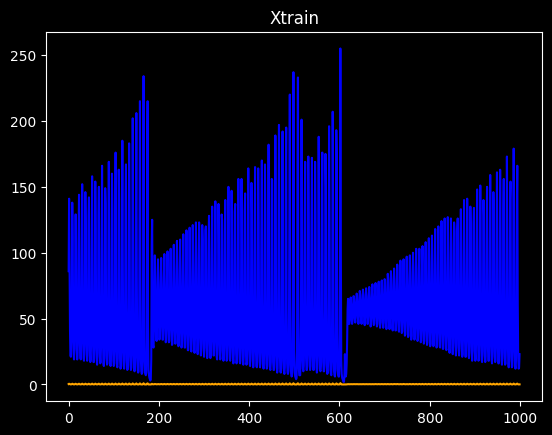

In [2]:
data = loadmat("Xtrain.mat")  
x_raw = data["Xtrain"].flatten()
print(x_raw.shape)
# Normalize
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x_raw.reshape(-1, 1)).flatten()
#X_scaled = scaler.inverse_transform(X_scaled.reshape(-1, 1)).flatten()

# plot 
plt.plot(x_raw, label="raw", c ="blue")
plt.plot(X_scaled, label="scaled", c ="orange")
plt.title("Xtrain")
plt.show()

In [3]:
# Hyperparameters
input_len = 20  
val_ratio = 0.2  # 20% 


def create_sequences(data, input_len):
    X, y = [], []
    for i in range(len(data) - input_len):
        X.append(data[i:i + input_len])
        y.append(data[i + input_len])
    return np.array(X), np.array(y)

# Load and scale data 
data = loadmat("Xtrain.mat")
X_raw = data["Xtrain"].flatten()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw.reshape(-1, 1)).flatten()

In [4]:
# model factories 
def build_rnn_model(input_len):
    model = keras.Sequential([
        layers.SimpleRNN(32, return_sequences=False, input_shape=(input_len, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model(input_len):
    model = keras.Sequential([
        layers.GRU(32, return_sequences=False, input_shape=(input_len, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_len):
    model = keras.Sequential([
        layers.LSTM(32, return_sequences=False, input_shape=(input_len, 1)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [7]:
# Config
input_lens = [10, 20, 30, 40, 50, 100, 250 , 500]  # grid search
models = {
    "RNN": build_rnn_model,
    "GRU": build_gru_model,
    "LSTM": build_lstm_model
}
val_ratio = 0.2
results = {name: [] for name in models}


In [8]:
# Run experiments
for input_len in input_lens:
    print(f"\n=== Input length: {input_len} ===")
    X_all, y_all = create_sequences(X_scaled, input_len)
    X_all = X_all.reshape(-1, input_len, 1)
    y_all = y_all.reshape(-1, 1)

    val_size = int(len(X_all) * val_ratio)
    X_train, X_val = X_all[:-val_size], X_all[-val_size:]
    y_train, y_val = y_all[:-val_size], y_all[-val_size:]

    for name, builder in models.items():
        print(f"Training {name}...")
        model = builder(input_len)
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=20, batch_size=32,
            verbose=1
        )
        final_train_loss = history.history["loss"][-1]
        final_val_loss = history.history["val_loss"][-1]

        results[name].append({
            "input_len": input_len,
            "train_loss": final_train_loss,
            "val_loss": final_val_loss
            })




=== Input length: 10 ===
Training RNN...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0721 - val_loss: 0.0076
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0145 - val_loss: 0.0030
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097 - val_loss: 0.0033
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - val_loss: 0.0034
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - val_loss: 0.0033
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0031
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0055 - val_loss: 0.0033
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - val_loss: 0.0027
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 12/20
25/25 ━━━

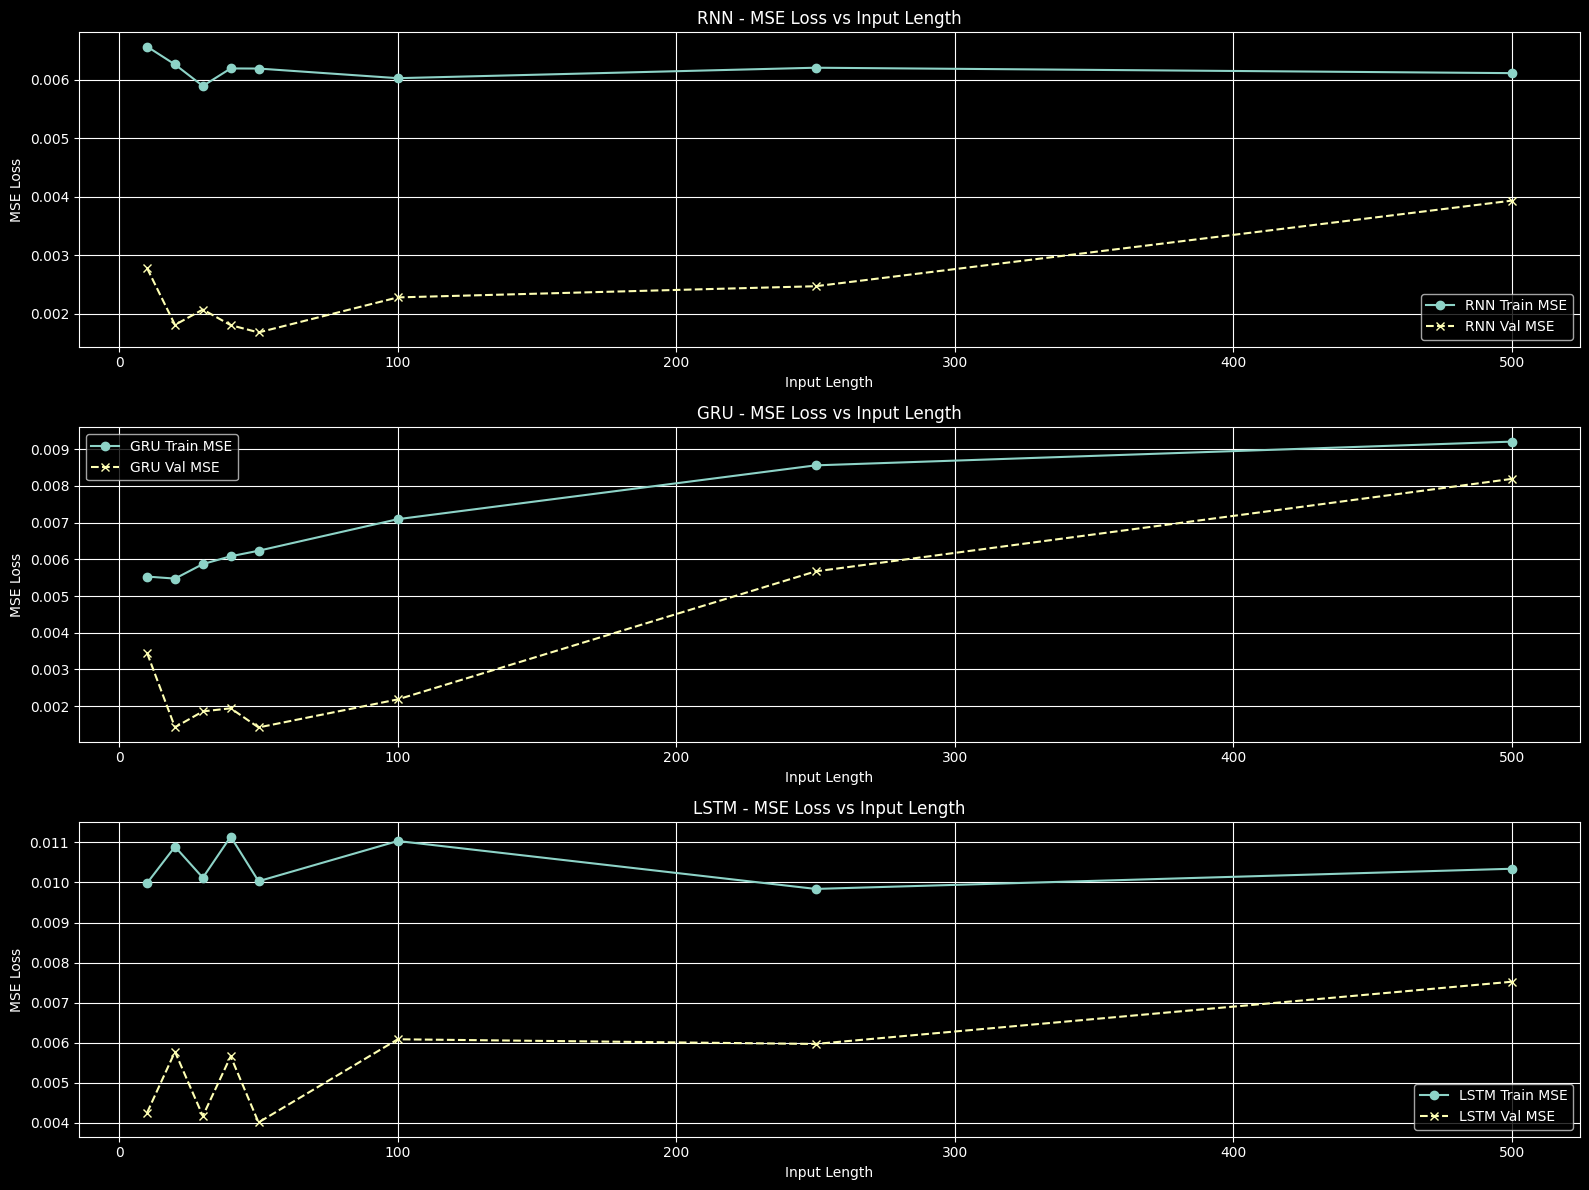

In [9]:
plt.figure(figsize=(16, 12))

for i, name in enumerate(models.keys(), start=1):
    model_results = results[name]
    input_lens_plot = [entry["input_len"] for entry in model_results]
    train_losses = [entry["train_loss"] for entry in model_results]
    val_losses = [entry["val_loss"] for entry in model_results]

    plt.subplot(len(models), 1, i)
    plt.plot(input_lens_plot, train_losses, marker='o', label=f"{name} Train MSE")
    plt.plot(input_lens_plot, val_losses, marker='x', linestyle='--', label=f"{name} Val MSE")
    plt.title(f"{name} - MSE Loss vs Input Length")
    plt.xlabel("Input Length")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
